# Práctica 9: Uso de SHAP

En esta novena práctica de la especialización de Machine Learning, nos familiarizaremos con SHAP (SHapley Additive exPlanations). SHAP es una herramienta muy usada en el ML que sirve para explicar las predicciones de un modelo, es decir, para entender por qué un modelo toma una determinada decisión.

Entrenaremos un modelo con un set de datos proporcionado y luego aplicaremos SHAP para explicar el funcionamiento del mismo.

## **1. Importación de datos y EDA**

### **Importación del CSV de datos a través de Google Drive**

Utilizaré la librería de google para poder montar mi drive y con la librería `pathlib` para definir la ruta de mi archivo y montarlo en un `DataFrame` de Pandas.

In [5]:
from google.colab import drive
# Montamos el drive para traernos "data.csv" al cuadernillo
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
import pandas as pd
from pathlib import Path

def carga_dataframe(path: Path):
  """
  Función para cargar un DataFrame desde un archivo CSV
  :param path: Ruta del archivo CSV
  :return: DataFrame con los datos
  """
  data = pd.read_csv(path)
  print("\nLa carga de los datos ha sido satisfactoria.")

  # Devuelvo el dataframe a través de la función
  return data

In [7]:
# Intentaré usar la clase Path de la librería pathlib como me recomendaste en la
# anterior práctica, si hay margen de mejora o no pensabas en este como el uso que
# le podía dar, comentamelo pls
from pathlib import Path

# Creo la ruta del archivo para poder importar el CSV del ejercicio
regular_path = Path("/content/drive/MyDrive/TS - Machine Learning")
data_path = regular_path / "M3_Interpretacion_Mejora_Modelos" / "3.2. Interpretacion de modelos ML" / "churn_data.csv"

In [8]:
# Utilizo la función definida arriba para traerme el CSV desde la ruta a su ubicación a Colab

data = carga_dataframe(data_path)
data.head() # Primer vistazo a los datos


La carga de los datos ha sido satisfactoria.


,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **EDA y preparación de los datos**

Encapsularé los métodos de análisis de datos en una función para poder pasarle mi DataFrame y que me de los resultados.

In [9]:
# En este bloque de código voy a escribir todas las funciones referentes al EDA

def analizar_data(data: pd.DataFrame, target: str):
  """
  Función para sacar un análisis exploratorio de los datos
  :param data: DataFrame con los datos
  :return: None
  """
  # Imprimimos por pantalla el conteo de filas y columnas con el tipo de dato de estas
  conteo_filas_columnas_tiposdato(data)

  # Imprimimos por pantalla las columnas que tengan nulos
  analizar_nulos(data)

  # Conteo de la variable target
  analizar_balance_target(data, target)

  # Finalmente sacamos un data.describe() para ver las estadísticas básicas
  print("\n📊 Análisis estadístico de los datos:")
  print(data.describe())
  print("\n")


def conteo_filas_columnas_tiposdato(data: pd.DataFrame):
  """
  Función para sacar el conteo de filas, columnas y tipos de dato de un DataFrame
  :param data: DataFrame con los datos
  :return: None
  """
  # Sacamos el número de filas, el de columnas
  print("Nº filas: " + str(data.shape[0]))
  print("Nº columnas: " + str(data.shape[1]))

  # Imprimimos por pantalla el nombre de las columnas y el tipo de dato que tienen
  print("\nNombre de columnas y tipo de dato de estas:")
  print(data.dtypes)


def analizar_nulos(data: pd.DataFrame):
  """
  Función para analizar los nulos de un DataFrame
  :param data: DataFrame con los datos
  :return: None
  """

  nulos = data.isnull().sum() # Cálculo de nulos
  ratio = (nulos/data.shape[0]) * 100 # Cálculo de ratios

  resumen = pd.DataFrame({
      'Nulos': nulos,
      'Ratio (%)': ratio
  })

  print("\n🗒️ Análisis de valores nulos:")
  print(resumen)

  print("\nNúmero de filas del DataFrame duplicadas:")
  print(data.duplicated().sum())


def analizar_balance_target(data: pd.DataFrame, target: str):
  """
  Función para analizar el balance de la variable target
  :param data: DataFrame con los datos
  :return: None
  """

  conteo = data[target].value_counts()
  ratio = (conteo/data.shape[0]) * 100

  resumen = pd.DataFrame({
      'Conteo': conteo,
      'Ratio': ratio
  })

  print("\n📊 Conteo y ratio de la variable target:")
  print(resumen)




In [10]:
# Defino la variable target que será 'Churn' en este caso
target = 'Churn'

# Llamo a la función de análisis
analizar_data(data, target)

Nº filas: 7043
Nº columnas: 9

Nombre de columnas y tipo de dato de estas:
customerID           object
tenure                int64
PhoneService         object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

🗒️ Análisis de valores nulos:
                  Nulos  Ratio (%)
customerID            0        0.0
tenure                0        0.0
PhoneService          0        0.0
Contract              0        0.0
PaperlessBilling      0        0.0
PaymentMethod         0        0.0
MonthlyCharges        0        0.0
TotalCharges          0        0.0
Churn                 0        0.0

Número de filas del DataFrame duplicadas:
0

📊 Conteo y ratio de la variable target:
       Conteo      Ratio
Churn                   
No       5174  73.463013
Yes      1869  26.536987

📊 Análisis estadístico de los datos:
            tenure  MonthlyCharges
count  7043.000000 

Viendo las columnas del DataFrame nos damos cuenta que tanto 'Contract', 'PaperlessBilling', 'PaymentMethod' y 'Churn' son columnas categóricas. Para el EDA nos conviene mapear estas columnas y tenerlas con valores numéricos. Para ello vamos a desarrollar una función que lo haga de manera automática.

También vemos que 'TotalCharges' es una columna de tipo *object* cuando debería ser una columna *float64* como la columna 'MonthlyCharges'.

Salta a la vista con esta primera vuelta de análisis que el ratio de la variable target 'Churn' está bastante desbalanceado. Esto quiere decir que nuestro modelo estará sesgado a pensar que predecir 'No' es mejor ya que aparece un 70% de las veces. Esto también lo veremos en SHAP en el que se verá el sesgo del modelo. Para evitar esto o paliarlo de alguna manera se podría hacer un **rebalanceo de clases**.

In [11]:
# Aquí desarrollaré una función para mapear las variables categoricas de cada dataset
def mapear_categoricas(data: pd.DataFrame):
  """
  Función para mapear las variables categóricas de un DataFrame
  :param data: DataFrame con los datos
  :return: DataFrame con las variables categóricas mapeadas
  :return: dict con los mapeos aplicados
  """
  data_mapeada = data.copy() # realizamos una copia del dataframe
  mapeos = {}

  # Detectamos las columnas categóricas
  columnas_categoricas = data.select_dtypes(include=['object','category']).columns

  for col in columnas_categoricas:
    valores_unicos = data[col].unique() # Obtenemos los valores unicos de esa columna
    if(len(valores_unicos) <= 10): # Si la columna tiene como maximo 10 valores únicos
      mapa = {valor: idx for idx, valor in enumerate(valores_unicos)} # Creo el mapeo con el valor y un índice
      data_mapeada[col] = data[col].map(mapa) # Aplicamos el mapa
      mapeos[col] = mapa # Almaceno el mapa para poder deshacer el mapeo

  return data_mapeada, mapeos

In [12]:
# Mapeamos las columnas del dataframe pero guardando una copia del original para el entrenamiento del modelo
data_original = data.copy()
data, mapeos = mapear_categoricas(data)

# Echamos un vistazo al diccionario de mapeos
print(mapeos)
# Comprobamos el cambio en el dataframe
data.head()

{'PhoneService': {'No': 0, 'Yes': 1}, 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2}, 'PaperlessBilling': {'Yes': 0, 'No': 1}, 'PaymentMethod': {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}, 'Churn': {'No': 0, 'Yes': 1}}


,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,0,0,0,0,29.85,29.85,0
1,5575-GNVDE,34,1,1,1,1,56.95,1889.5,0
2,3668-QPYBK,2,1,0,0,1,53.85,108.15,1
3,7795-CFOCW,45,0,1,1,2,42.30,1840.75,0
4,9237-HQITU,2,1,0,0,0,70.70,151.65,1


In [13]:
# Transformamos la columna 'TotalCharges' de object a float64
original = data.copy() # Realizamos una copia del dataframe original

data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [14]:
# Volvemos a lanzar la función de análisis
analizar_data(data, target)

Nº filas: 7043
Nº columnas: 9

Nombre de columnas y tipo de dato de estas:
customerID           object
tenure                int64
PhoneService          int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

🗒️ Análisis de valores nulos:
                  Nulos  Ratio (%)
customerID            0   0.000000
tenure                0   0.000000
PhoneService          0   0.000000
Contract              0   0.000000
PaperlessBilling      0   0.000000
PaymentMethod         0   0.000000
MonthlyCharges        0   0.000000
TotalCharges         11   0.156183
Churn                 0   0.000000

Número de filas del DataFrame duplicadas:
0

📊 Conteo y ratio de la variable target:
       Conteo      Ratio
Churn                   
0        5174  73.463013
1        1869  26.536987

📊 Análisis estadístico de los datos:
            tenure  PhoneService     Contract  Paperle

Como hemos pasado a tener varios valores que no eran nulos en la columna 'TotalCharges' a valores nulos, eso quiere decir que no eran númericos. Vamos a buscar qué eran estos valores para ver si eran relevantes o no.

In [15]:
mask = data['TotalCharges'].isnull() # Creamos una máscara para buscar los valores originales

# Mostramos los valores que se volvieron NaN
print(original.loc[mask])

      customerID  tenure  PhoneService  Contract  PaperlessBilling  \
488   4472-LVYGI       0             0         2                 0   
753   3115-CZMZD       0             1         2                 1   
936   5709-LVOEQ       0             1         2                 1   
1082  4367-NUYAO       0             1         2                 1   
1340  1371-DWPAZ       0             0         2                 1   
3331  7644-OMVMY       0             1         2                 1   
3826  3213-VVOLG       0             1         2                 1   
4380  2520-SGTTA       0             1         2                 1   
5218  2923-ARZLG       0             1         1                 0   
6670  4075-WKNIU       0             1         2                 1   
6754  2775-SEFEE       0             1         2                 0   

      PaymentMethod  MonthlyCharges TotalCharges  Churn  
488               2           52.55                   0  
753               1           20.25        

Como los valores en el dataframe original están vacíos, esto quiere decir que no afectarán demasiado al modelo, además sólo representan 0.15% del total de las muestras. Por estas razones lo más seguro y limpio es eliminar estas filas del dataframe.

In [16]:
# Eliminamos los valores NaN
data = data.dropna()

# Eliminamos también la columna customerID para poder sacar la correlación de variables
"""
No he eliminado esta columna antes porque al ser transacciones individuales podría haber filas duplicadas
pero a mi modo de ver no son filas despreciables ya que serían filas que van a ser relevantes para el modelo
porque representan transacciones iguales de distintos clientes.
"""
data = data.drop(['customerID'], axis=1)

In [17]:
# Ultima vuelta de la función de análisis para comprobar
analizar_data(data, target)

Nº filas: 7032
Nº columnas: 8

Nombre de columnas y tipo de dato de estas:
tenure                int64
PhoneService          int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

🗒️ Análisis de valores nulos:
                  Nulos  Ratio (%)
tenure                0        0.0
PhoneService          0        0.0
Contract              0        0.0
PaperlessBilling      0        0.0
PaymentMethod         0        0.0
MonthlyCharges        0        0.0
TotalCharges          0        0.0
Churn                 0        0.0

Número de filas del DataFrame duplicadas:
79

📊 Conteo y ratio de la variable target:
       Conteo      Ratio
Churn                   
0        5163  73.421502
1        1869  26.578498

📊 Análisis estadístico de los datos:
            tenure  PhoneService     Contract  PaperlessBilling  \
count  7032.000000   7032.000000  7032.000000    

Como bien comentamos ahora las filas duplicadas en el DataFrame son 79 pero por lo ya comentado anteriormente en el código.

Las variables más correladas con la variable target son el tipo de contrato que se tiene, y la tendencia. Estando estas negativamente correladas.

In [18]:
# Sacamos la tabla de correlación de variables con la variable target
print(data.corr()['Churn'])

tenure             -0.354049
PhoneService        0.011691
Contract           -0.396150
PaperlessBilling   -0.191454
PaymentMethod      -0.262918
MonthlyCharges      0.192858
TotalCharges       -0.199484
Churn               1.000000
Name: Churn, dtype: float64


Las variables más correladas con la variable target son el tipo de contrato que se tiene, y la tendencia. Estando estas negativamente correladas.

### **Análisis Gráfico**

Realizaremos un pequeño análisis gráfico para ver cuántos valores atípicos tenemos y la correlación de las variables con la variable target de una manera gráfica. También de la distribución de los datos.

In [19]:
# Importamos la librería para las gráficas
import matplotlib.pyplot as plt

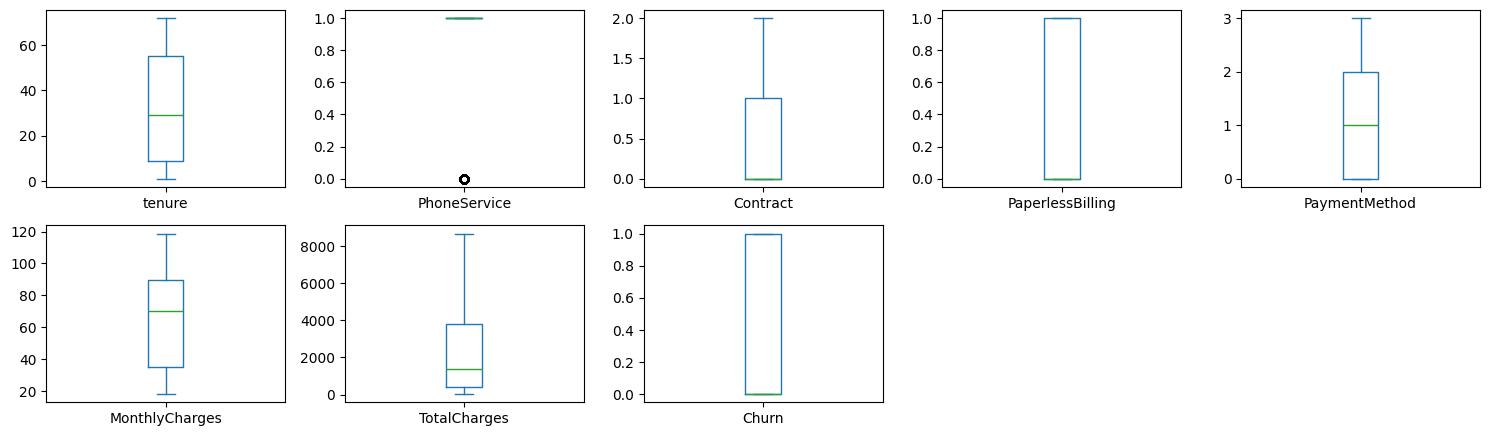

In [20]:
# Boxplots de las variables

data.plot(
    kind='box',
    layout= (7, 5),
    figsize=(15, 15),
    subplots=True,
    sharex=False,
    sharey=False
)
plt.tight_layout()
plt.title("Boxplot de variables")
plt.show()

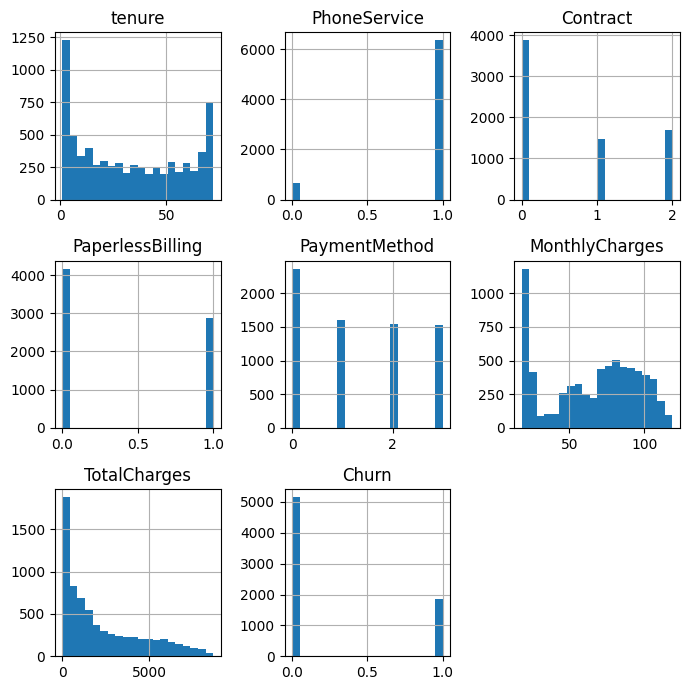

In [21]:
# Histograma de todas las variables

data.hist(figsize=(7,7), bins=20)
plt.tight_layout()
plt.title("Histograma de variables")
plt.show()

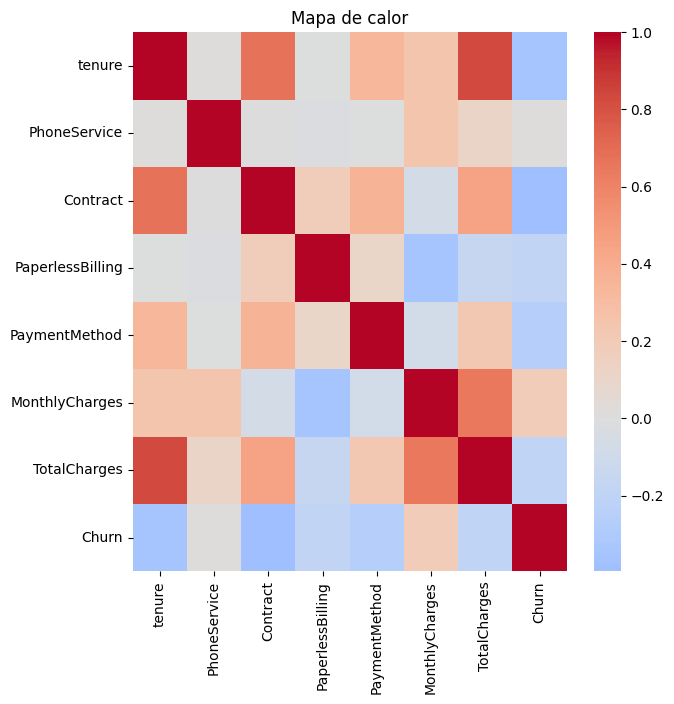

In [22]:
# Mapa de calor para ver la correlacion
import seaborn as sns # importamos libreria para heatmap

corr = data.corr(numeric_only=True)

plt.figure(figsize=(7,7))
sns.heatmap(corr, annot=False, cmap="coolwarm", center= 0)
plt.title("Mapa de calor")
plt.show()

De las gráficas extraemos que el carácter categórico hace que la correlación sea baja (no hay relación lineal entre la variable target y el resto). Lo que no quiere decir que las variables sean inútiles sino que no hay relación lineal entre ellas.

## **2. Entrenamiento del Modelo**

Como nos encontramos ante una situación en la que tenemos muchas variables categóricas utilizaremos un modelo de **Decision Tree** para hacer las predicciones. Esto es porque manejan bien las interacciones entre variables categóricas y no dependen de correlaciones lineales.

También, este modelo va a aceptar el tipo de codificación de variables categóricas que he hecho manualmente. Aunque también podríamos haber usado un `LabelEncoder`.

### **Train/Test Split**

In [23]:
# Importamos lo necesario para hacer la separacion de train/test
from sklearn.model_selection import train_test_split

X = data.drop(target, axis=1)
y = data[target]

# La separación sera 80/20, la estándar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # Uso strarify para mantener el equiliibrio de clases en la separación

### **Entrenamiento del modelo**

In [24]:
from sklearn.tree import DecisionTreeClassifier

# Creo el modelo
model = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=6,
    min_samples_leaf=5
)
# Con class_weight='balanced' conseguimos que se penalice más los errores sobre la clase minoritaria
# ya que tenemos un desbalanceo de clases considerable

# Entreno el modelo
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=5,
                       random_state=42)

### **Validación**

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Función para representar la matriz de confusión de una manera más visual
def matriz_confusion(y_test, y_pred):
  plt.figure(figsize=(5,5))
  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Matriz de confusion')
  plt.xlabel('Predicción')
  plt.ylabel('Valor real')
  plt.show()

# Función para imprimir un resumen de las métricas de un modelo
def metricas(y_test, y_pred):
  print("\nEvaluación en el conjunto de test:")
  print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
  print(f"F1-Score final: {f1_score(y_test, y_pred):.4f}")
  print("")
  matriz_confusion(y_test, y_pred)
  print("\nReporte de clasificación:")
  print(classification_report(y_test, y_pred))


Evaluación en el conjunto de test:
Accuracy: 0.7214
F1-Score final: 0.6000



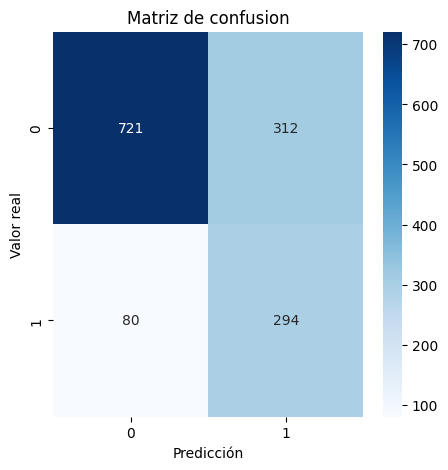


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



In [26]:
y_pred = model.predict(X_test)

metricas(y_test, y_pred)

Con los parámetros entrenados son con los que mejore números he sacado para este modelo, el f1-score de la clasee '1' no mejora más allá del 0.60. El modelo prioriza detectar churners (recall alto), lo cual es bueno si el coste de perder un cliente es alto. Sin embargo **genera muchos falsos positivos**.

Como creo que no es el objetivo de esta práctica, pasaré al apartado de aplicar **SHAP** al conjunto de datos, en vez de estar haciendo tuning del modelo en sí.

## **3. Aplique del paquete SHAP**

Ahora pasaré a aplicar el paquete SHAP sobre el conunto de datos que tenemos.

In [27]:
# importamos las dependencias shap
import shap

# Creamos el objeto explicador
explainer = shap.TreeExplainer(model)

In [28]:
# Calculamos los valores de SHAP
shap_values = explainer.shap_values(X_test)

In [29]:
type(shap_values), np.array(shap_values).shape

(numpy.ndarray, (1407, 7, 2))

### **Visualización de interpretaciones**

In [30]:
# Valores SHAP solo para la clase positiva (churn=yes)
shap_values_1 = shap_values[:,:,1]

#### **Gráfico de Resumen**

Muestra qué variables tienen más impacto global y cómo afectan (de manera positiva o negativa):

- Cada punto es una observación.
- El coloindica el valor de la característica (rojo=alto, azul=bajo).
- El **eje X** muestra cuánto influye esa variable en la predicción.
- El orden muestra la importancia (las más arriba son las más influyentes).

De manera explicativa y general, este gráfico responde a *¿Qué variables influyen más en la decisión del modelo en general?*

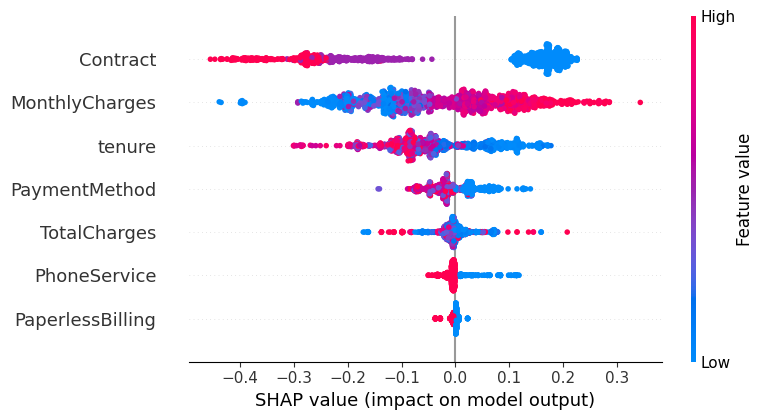

In [31]:
# Mostramos el gráfico por pantalla
shap.summary_plot(
    shap_values_1,
    X_test,
    plot_type="dot"
)

Como bien hemos apuntado el orden de las características indica la importancia de las mismas. Si nos fijamos tanto *Contract*, *tenure* y *MonthlyCharges* son las características más importantes de este modelo. De estas 3 haremos el gráfico de dependencias.

#### **Gráficos de dependencia**

Para interpretar estos gráficos tendremos en cuenta:

- Cada punto es un cliente.
- Eje X → valor de la característica.
- Eje Y → contribución SHAP.
- Color → otra característica con la que más interactúa (por defecto, SHAP la elige automáticamente).

En general, se podría decir que este gráfico responde a la pregunta *¿Cómo influye esta variable en la probabilidad de churn?*

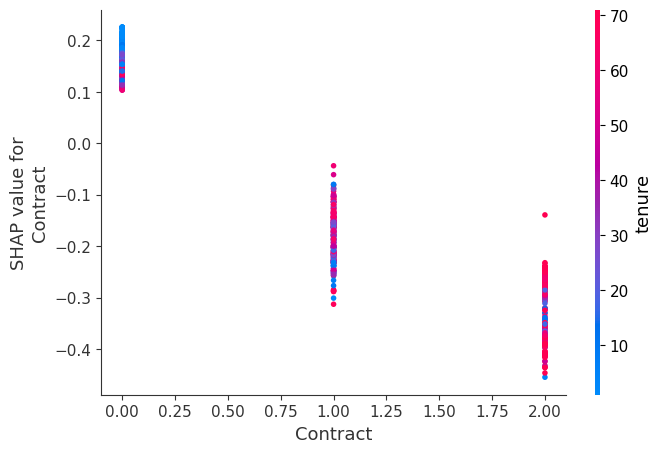

In [32]:
# Gráfico de dependencia para Contract
shap.dependence_plot(
    "Contract",
    shap_values_1,
    X_test,
)

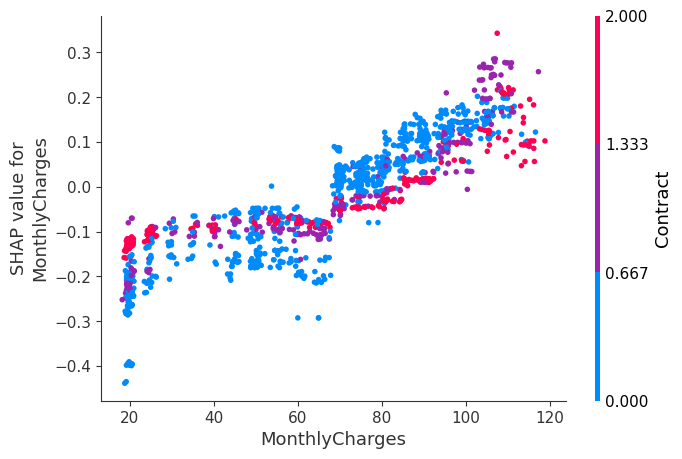

In [33]:
# Gráfico de dependencia para MonthlyCharges
shap.dependence_plot(
    "MonthlyCharges",
    shap_values_1,
    X_test,
)

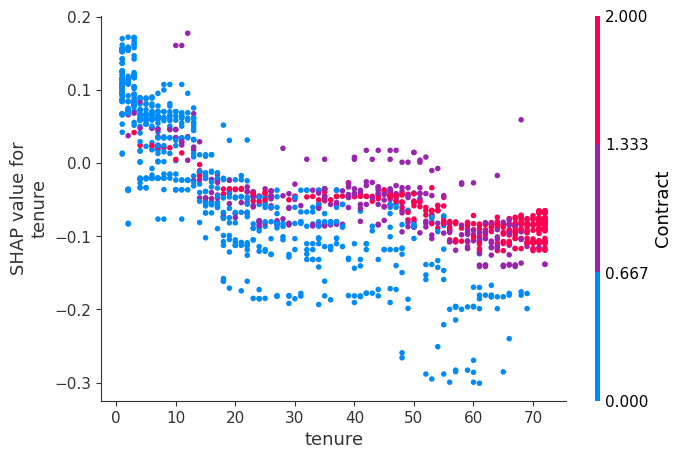

In [34]:
# Gráfico de dependencia para Tenure
shap.dependence_plot(
    "tenure",
    shap_values_1,
    X_test,
)

#### **Gráfico de Fuerza**

Este gráfico muestra qué variables empujan la predicción hacia el *si* o hacia el *no*. Es un gráfico individual para cada muestra.

Interpretación:

- Las flechas rojas empujan hacia churn (1).
- Las flechas azules empujan hacia no churn (0).
- La magnitud muestra qué variables más influyen en esa predicción.

In [35]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],     # valor base (predicción media)
    shap_values_1[4, :],        # contribuciones de cada feature
    X_test.iloc[4, :]                # valores reales de las features
)

In [36]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[1],     # valor base (predicción media)
    shap_values_1[1, :],        # contribuciones de cada feature
    X_test.iloc[1, :]                # valores reales de las features
)

#### **Opcional: Gráfico de Cascada**

En general es una versión moderna del gráfico de fuerza. También es un gráfico para **muestras individuales** en el que se ve más claramente la influencia de cada característica en la decisión del modelo.

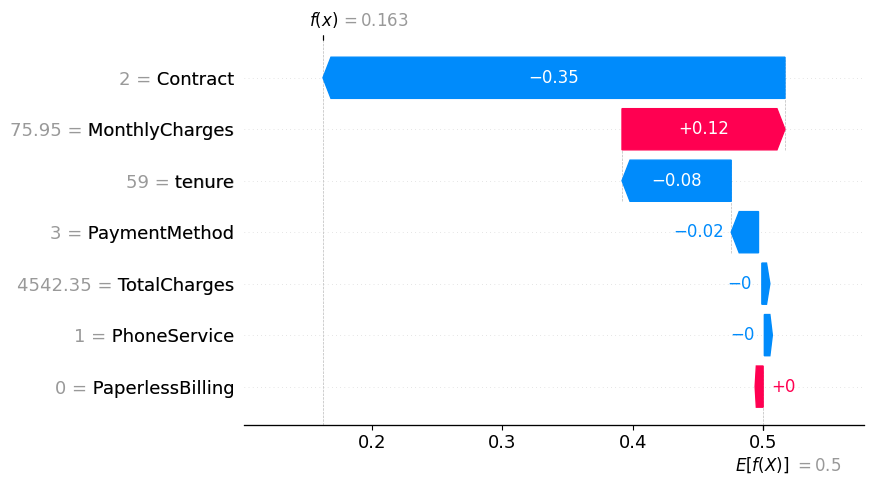

In [38]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_1[4],
        base_values=explainer.expected_value[1],
        data=X_test.iloc[0, :],
        feature_names=X_test.columns
    )
)

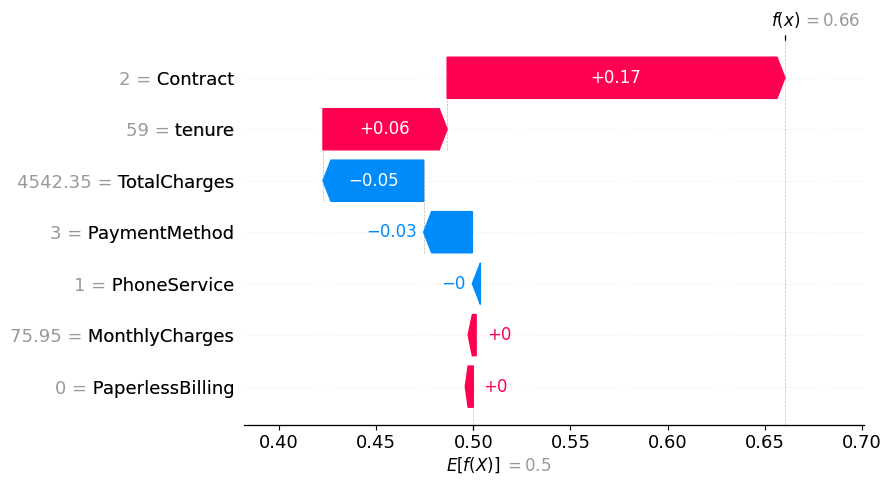

In [37]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_1[1],
        base_values=explainer.expected_value[1],
        data=X_test.iloc[0, :],
        feature_names=X_test.columns
    )
)

## **4. Conclusiones sobre los resultados**

### **Impacto de las características**

#### **Gráfico de Resumen (SummaryPlot)**

Si nos fijamos en la gráfica de resumen de shap, como bien indicamos en el eje Y se representa el valor de las carácterísticas, estando más arriba las características que más impacto tienen. La característica más importante es el **tipo de contrato**, teniendo valores rojos a la derecha y azules a la izquierda, lo que quiere decir que contratos mes a mes son más propensos de predecir el "si". Mientras que los contratos más largos son menos propensos a hacer churn (por eso se ubican a la izquierda en el eje X de esta característica).

Dos características importantes son *tenure* y *MonthlyCharges*. Si nos fijamos en la primera en el gráfico resumen vemos que funciona igual que *contract* con los puntos rojos (valores altos) a la izquierda en el eje X y bicerversa, esto tiene sentido ya que los clientes con valores altos de antiguedad tienen menos probabilidades o, empujan menos al "si", que los clientes que no llevan tanto tiempo con la compañía. Sin embargo, la característica *MonthlyCharges* funciona al contrario, con los valores altos a la derecha en el eje X de la gráfica, si pensamos esto es evidente, los clientes cuyos cargos mensuales son más altos empujan más a la predicción del "sí".

#### **Gráfico de Dependencia (DependencePlot)**

Si nos fijamos ahora en los gráficos de dependencia generados nos sentimos apoyados en las anteriores hipótesis. En el gráfico referente al tipo de contrato vemos que los valores más altos de shap los tienen los contratos más bajos (contratos mes a mes), mientras que los contratos de un año y de dos años generan un valor shap negativo (empuja la predicción al "no"). Además viendolo combinado con la antigüedad los puntos rojos se acumulan en mayor proporcion con los contratos de dos años, en menos proporción en los contratos de un año y casi inaparentes en los contratos mes a mes.

Aunque menos importantes también es interesante echarle un vistazo a las gráficas de dependencia de *tenure* y *MonthlyCharges* que nos reafirman como ya veníamos diciendo. Por ejemplo vemos que en el gráfico de la antigüedad los valores más a la izquierda en el eje X de la gráfica (baja antiguedad) tienen un valor shap más alto (empujan más al "sí"). Mientras que en la gráfica del cargo mensual de los clientes es al contrario, los valores más a la derecha del eje X de la gráfica son los que tienen mayor valor shap, quiere decir, más peso hacia el churn (baja de servicio).

#### **Gráficos individuales (de Fuerza y Cascada)**

En estos gráficos también vemos que para el primero que es un cliente del que se ha predicho que no va a darse de baja tiene unos cargos mensuales bajos, un contrato de dos años y una antigüedad alta. Mientras que el segundo que sí ha dicho que se va a dar de baja tiene unos gastos mensuales mucho más elevados, un contrato mes a mes, y una antigüedad mucho menor que el otro cliente.

### **Cómo ayuda SHAP a identificar posibles sesgos o errores en el modelo**

SHAP ayuda a **detectar sesgos o errores** porque muestra cómo cada característica ingluye en las predicciones del modelo, tanto de forma positiva como negativa, y de manera consistente para cada observación.

Al analizar los valores SHAP:

- Si una característica tiene valores muy altos o muy bajos asociiados sistemáticamente a una clase concreta, puede indicar un sesgo del modelo hacia ese atributo. Como en este ejemplo el modelo está sesgado por la característica del tipo de contrato que tenga el cliente.

- También permite identificar **características irrelevantes o redundantes** que el modelo está utilizando indebidamente.

- Si se observan patrones incoherentes (por ejemplo, una variable debería aumentar la probabilidad de una clase pero los valores SHAP muestran lo contrario), eso revela **posibles errores de entrenamiento o de preprocesamiento de los datos**.

### **Qué ventajas ofrece SHAP frente a otros métodos de interpretabilidad**

SHAP presenta varias ventajas clave frente a otros métodos como LIME o los gráficos de importancia tradicionales:

1. **Basado en teoría sólida**: se fundamenta en la teoría de los Shapley values de la tería de juegos, lo que garantiza una **distribución justa e interpretable de la contribución** de cada variable.

2. **Coherencia global y local**: explica tanto el **comportamiento general del modelo** (importancia media de cada caaracterística) como las **predicciones individuales**.

3. **Comparabilidad**: podemos comparar los valores SHAP entre modelos o instancias de estos.

4. **Visualizaciones intuitivas**: los gráficos de resumen, dependencia y fuerza/cascada nos da una imagen clara y limpia del funcionamiento de cada característica en el modelo que estamos analizando. Tanto del valor de las características como de la dirección que toman (negativa o positiva).